In [40]:
from dotenv import load_dotenv
import pandas as pd
import os
import ast
from helpers.bar_charts import plot_frequency_of_responses_bar, ChartType, plot_relative_distribution_horizontal_bar
from helpers.likert_charts import plot_likert_response, LIKERT_SCALES, translate_to_agreeing, translate_to_time, plot_likert_response_without_text
from helpers.colormap_factory import get_default_colormap, get_first_colors_from_palette_as_colorlist, blend_hex_colors

load_dotenv(override=True)

RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
BUCKET_SIZE = os.getenv("BUCKET_SIZE")

path_to_questionnaire_storage = '/Users/annemariewittig/Master/codeprodllm-surveys/COMP/ini'
company = RESULTS_DIRECTORY.split('/')[-1]

# if repositories_to_delete:
#     df = df[~df["repository"].isin(repositories_to_delete)]
users_to_skip = ast.literal_eval(os.getenv("PARTICIPANTS_TO_REMOVE", ""))

In [41]:
path_to_questionnaire_storage = path_to_questionnaire_storage.replace('COMP', company)

In [42]:
counting_columns = ['projectSize', 'education. Was ist Ihr höchster Bildungsabschluss?','framework. Welche Frameworks nutzen Sie?', 'ide. Welche IDE nutzen Sie?', 'progLang. Was ist/sind Ihre primäre Programmiersprache/n?']
counting_columns = [col.split('.', 1)[0].strip() if '.' in col else col for col in counting_columns]

median_columns = ['profYearsProgramming', 'progExp', 'yearsProgramming']
likert_columns = ['progExpCompared[CEE1]', 'progExpCompared[CTE]', 'progExpCompared[PE]']

In [43]:
import json 
import ast

PARTICIPANTS_TO_REMOVE = ast.literal_eval(os.getenv("PARTICIPANTS_TO_REMOVE", ""))
mapping_path = f'/Users/annemariewittig/Master/repositoryanalysis/{RESULTS_DIRECTORY.split('/')[-1]}/by_person/mapping.json'

# Load the mapping JSON
with open(mapping_path, 'r') as f:
    participant_mapping = json.load(f)

order_of_repositories = list(participant_mapping[key]['SYNONYM'] for key in participant_mapping.keys() if 'XX' not in participant_mapping[key]['SYNONYM'])
renaming_dict = {key: participant_mapping[key].get('SYNONYM', key) for key in participant_mapping.keys()}

# mirror renaming_dict so that key = value and value = key
renaming_dict_mirror = {v: k for k, v in renaming_dict.items()}

In [44]:
merged_df_for_filtering = pd.read_csv(f"{RESULTS_DIRECTORY}/merged_metrics_{BUCKET_SIZE}.csv")

def filter_and_remove_participants(df, participant_column='participantId'):
    if PARTICIPANTS_TO_REMOVE:
        df = df[~df[participant_column].isin(PARTICIPANTS_TO_REMOVE)]
    participants_of_merged = merged_df_for_filtering['repository'].unique()
    # rename participants_of_merged to match the renaming_dict
    participants_of_merged = [renaming_dict_mirror.get(repo, repo) for repo in participants_of_merged]
    

    df = df[df[participant_column].isin(participants_of_merged)]
    # Reset index after filtering

    df.reset_index(drop=True, inplace=True)
    return df

In [45]:
describing_values = {}

general.csv
programming.csv
profYearsProgramming


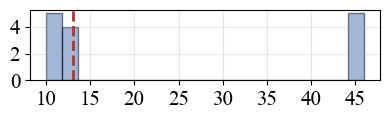

[13. 46. 46. 10. 46. 46. 10. 13. 13. 10. 10. 46. 10. 13.]
progExp


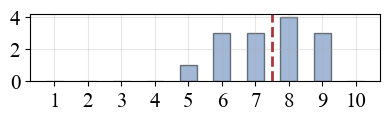

[6 7 9 9 6 8 8 6 5 7 8 7 9 8]
yearsProgramming


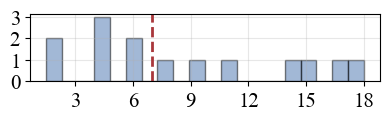

[ 1.5  4.   6.  17.   4.   8.  14.   2.   9.  15.  11.   6.  18.   4. ]
Participants pre: 20 Participants post: 14


In [54]:
import numpy as np
path_to_company_folder = path_to_questionnaire_storage.replace('COMP', company)
files = ['general.csv', 'programming.csv']
participants_pre = []
participants_post = []
for file in os.listdir(path_to_company_folder):
    if file in files:
        print(file)
        path_to_file = os.path.join(path_to_company_folder, file)
        df = pd.read_csv(path_to_file, index_col=False)
        # Rename all columns: split at first. use [0]
        df.columns = df.columns.str.split('.').str[0]
        
        # Filter users
        participants_pre.extend(df['participantId'].unique())
        df = filter_and_remove_participants(df)
        participants_post.extend(df['participantId'].unique())

        for column in median_columns:
            if column in df.columns:
                df[column] = pd.to_numeric(df[column], errors='coerce')
                median = df[column].median()
                print(column)
                # create a visualization of the distribution of the column that is wide but not tall
                if median > 0:
                    import matplotlib.pyplot as plt

                    # Create a wide but not tall histogram
                    plt.figure(figsize=(4, 1.3))
                    if column == 'progExp':
                        bins = np.arange(0.5, 10.6, 1)  # Bins centered on integers 1 to 10
                        width = 0.5
                    else:
                        bins = 20  # Default bin count
                        width = None

                    plt.hist(df[column].dropna(), bins=bins, edgecolor='black', alpha=0.5, color='#4672AF', rwidth=width)
                    plt.axvline(median, color='#a9373b', linestyle='--', linewidth=2, label=f'Median: {median}')
                    # plt.xlabel(column)
                    # plt.ylabel('Frequency')
                    # plt.legend()
                    plt.grid(True, alpha=0.3)
                    
                    # Force at least 5 ticks on x-axis and ensure integer positions
                    from matplotlib.ticker import MaxNLocator
                    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins='auto', min_n_ticks=5, integer=True))
                    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins='auto', min_n_ticks=3, integer=True))
                    
                    if column == 'progExp':
                        plt.xticks(range(1, 11), fontsize=15)
                        # plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

                    else:
                        plt.xticks(fontsize=15)
                    plt.yticks(fontsize=15)
                    
                    plt.tight_layout()
                    
                    # Save the plot
                    plot_path = f'./graphics/participant_table/{column}_distribution.png'
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                    plt.show()
                    
                    print(df[column].values)
                    # Store the median value for later use
                    describing_values[column] = {
                                                    'median': median,
                                                    'plot_path': plot_path
                                                }
print("Participants pre:", len(set(participants_pre))
      , "Participants post:", len(set(participants_post)))

In [47]:

path_to_company_folder = path_to_questionnaire_storage.replace('COMP', company)
files = ['general.csv', 'programming.csv']

for file in os.listdir(path_to_company_folder):
    if file in files:
        print(file)
        path_to_file = os.path.join(path_to_company_folder, file)
        df = pd.read_csv(path_to_file, index_col=False)
        # Rename all columns: split at first. use [0]
        df.columns = df.columns.str.split('.').str[0]
        print(df.columns)
        # Filter users
        df = filter_and_remove_participants(df)

        for column in counting_columns:
            if column in df.columns:
                print(f"Counts for column '{column}':")
                values = df[column].dropna().tolist()
                # Count occurrences of each value
                counts = {}
                for value in values:
                    values = value.split(',') if ',' in value else [value]
                    for v in values:
                        v = v.strip()
                        if v in counts:
                            counts[v] += 1
                        else:
                            counts[v] = 1

                # Sort the counts dictionary by value
                counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
                
                # Create a DataFrame from the counts
                counts_df = pd.DataFrame(list(counts.items()), columns=['response', 'count'])
                print (counts_df)

general.csv
Index(['participantId', 'projectSize', 'projectteam'], dtype='object')
Counts for column 'projectSize':
  response  count
0      mid      7
1      big      6
2    small      1
programming.csv
Index(['participantId', 'education', 'framework', 'ide',
       'profYearsProgramming', 'progExp', 'progExpCompared[CEE1]',
       'progExpCompared[CTE]', 'progExpCompared[PE]', 'progLang',
       'progLangExp[CSharp]', 'progLangExp[C]', 'progLangExp[Java]',
       'progLangExp[Other]', 'progLangExp[Plus]', 'progLangExp[Python]',
       'progLangExp[TSJS]', 'yearsProgramming'],
      dtype='object')
Counts for column 'education':
  response  count
0        8      8
1    -oth-      2
2        7      2
3        9      1
4        6      1
Counts for column 'framework':
      response  count
0  Spring Boot      9
1      Angular      8
2     React.js      3
3      Quarkus      2
Counts for column 'ide':
                  response  count
0  Jetbrains IDE (IntelliJ     12
1                  P

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from matplotlib.colors import to_hex

blended = blend_hex_colors('#BD6261', '#4672AF', 50)
print(blended)
# 1. Get 'vlag' colormap and extract pure left and right colors
vlag = colormaps["vlag"]
ryb = colormaps["RdYlBu_r"]
left_color = to_hex((70/255, 114/255, 175/255, 1))   # Deep blue
middle_color = "#DDDDDD"
right_color = to_hex((189/255, 98/255, 97/255, 1))  # Deep red
colors = [right_color, middle_color, left_color]
colors = [colors[2], blend_hex_colors(colors[2], colors[1], 50), colors[1], blend_hex_colors(colors[0], colors[1], 50), colors[0]]
print(colors)
from matplotlib import pyplot as plt


def in_table_likert_plot(values, colors = colors, filename=None, text_off = (-86, 44), left_label='A', right_label='B', left_offset = -105, right_offset = + 105):
    fig, ax = plt.subplots(1, figsize=(22, 1.3))

    offset = values[2]/2
        
    plt.barh(1, values[0], color = colors[0], height = 0.1, left=-values[0]-values[1] - offset)
    plt.barh(1, values[1], color = colors[1], height = 0.1, left=-values[1] - offset)
    plt.barh(1, values[2], color = colors[2], height = 0.1, left= -offset)
    plt.barh(1, values[3], color = colors[3], height = 0.1, left=offset)
    plt.barh(1, values[4], color = colors[4], height = 0.1, left=values[3] + offset)

    ax.axvline(0, color='black', linestyle='--', dashes=(5, 2), linewidth=6)


    plt.xlim(-100,100)
    plt.axis('off')
    plt.rcParams.update({'font.family': 'Times New Roman'})

    # Add the left and right labels
    plt.text(left_offset, 0.985, left_label, fontsize= 90, ha='right', va='center')  # Adjust positioning as needed
    plt.text(right_offset, 0.985, right_label, fontsize= 90, ha='left', va='center')  # Adjust positioning as needed

    # plt.title(column)
    
    # Dynamically calculate label positions
    # total_left_extent = -values[0] - values[1] - 10 - (values[2]/2)
    # total_right_extent = values[3] + values[4] + 10 + (values[2]/2)
    
    # # Add the left and right labels close to the bars
    # plt.text(total_left_extent, 1, left_label, fontsize=68, ha='right', va='center')  # Adjust offset (-2) for slight padding
    # plt.text(total_right_extent, 1, right_label, fontsize=68, ha='left', va='center')  # Adjust offset (+2) for slight padding

    if filename:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

#816a88
['#4672af', '#91a7c6', '#DDDDDD', '#cd9f9f', '#bd6261']


progExpCompared[CEE1]
progExpCompared[CEE1]
Very inexperienced                       0.0
Inexperienced                            1.0
Neither inexperienced nor experienced    7.0
Experienced                              2.0
Very experienced                         4.0
Name: count, dtype: float64
progExpCompared[CEE1]
Very inexperienced                        0.000000
Inexperienced                             7.142857
Neither inexperienced nor experienced    50.000000
Experienced                              14.285714
Very experienced                         28.571429
Name: count, dtype: float64
progExpCompared[CTE]
progExpCompared[CTE]
Very inexperienced                       0.0
Inexperienced                            0.0
Neither inexperienced nor experienced    6.0
Experienced                              4.0
Very experienced                         4.0
Name: count, dtype: float64
progExpCompared[CTE]
Very inexperienced                        0.000000
Inexperienced                  

/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_62781/3568863930.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].replace({
/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_62781/3568863930.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

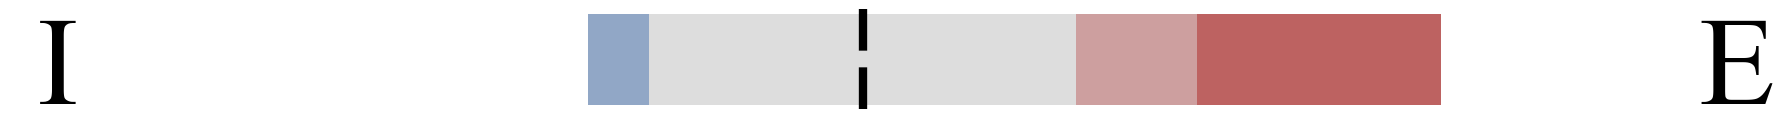

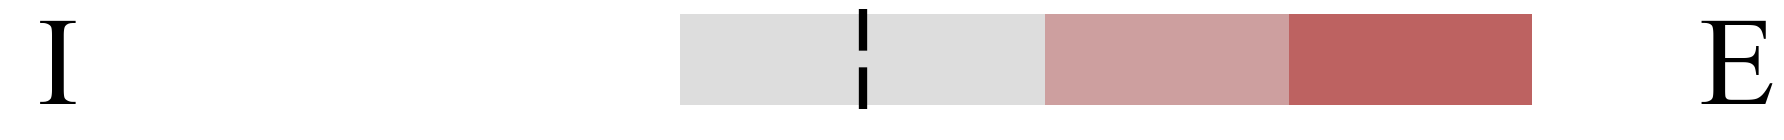

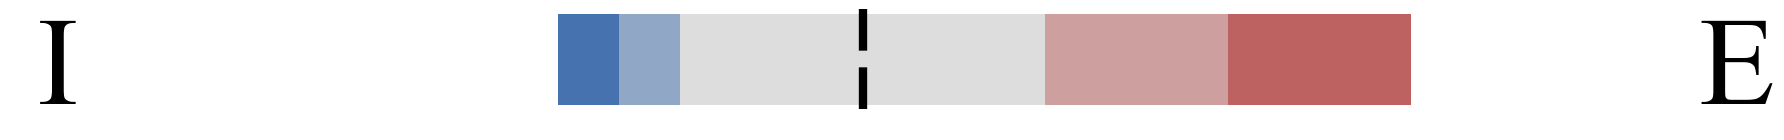

In [49]:

path_to_company_folder = path_to_questionnaire_storage.replace('COMP', company)
files = ['general.csv', 'programming.csv']

for file in os.listdir(path_to_company_folder):
    if file in files:
        path_to_file = os.path.join(path_to_company_folder, file)
        df = pd.read_csv(path_to_file, index_col=False)
        # Rename all columns: split at first. use [0]
        df.columns = df.columns.str.split('.').str[0]
        # Filter users
        df =  filter_and_remove_participants(df)

        for column in likert_columns:
            if column in df.columns:
                print(column)
                df[column] = pd.to_numeric(df[column], errors='coerce')
                median = df[column].median()
                plot_path = f'./graphics/participant_table/{column}_likerts.png'
                # 'likert': ["Very inexperienced", "Inexperienced", "Neither inexperienced nor experienced", "Experienced", "Very experienced"],
                df[column].replace({
                    1: "Very inexperienced",
                    2: "Inexperienced",
                    3: "Neither inexperienced nor experienced",
                    4: "Experienced",
                    5: "Very experienced"
                }, inplace=True)
                
                likert_levels = LIKERT_SCALES['EXPERIENCE']['likert']
                
                normalized_counts = {}
                # Reindex to ensure all Likert levels are represented and fill any missing values with 0
                counts = df[column].value_counts().reindex(likert_levels).fillna(0)
                print(counts)
                # Calculate the percentage of each Likert response
                counts = counts.astype(float)
                percentages = (counts / counts.sum()) * 100
                print(percentages)
                normalized_counts[column] = (counts / counts.sum()) * 100  # convert to percentages

                for question, values in normalized_counts.items():
                    # Convert to list to match expected input format for `in_table_likert_plot`
                    values_list = values.tolist()

                    in_table_likert_plot(values_list, colors=colors, filename=plot_path, left_offset=-92, right_offset=98, left_label='I', right_label='E')

                
                describing_values[column] = {
                                'median': median,
                                'plot_path': plot_path
                }
    else:
        print(f"Column '{column}' not found in {file}.")
            
                

In [50]:
import json
with open('/Users/annemariewittig/Master/codeprodllm-surveys/flattened_ini_mapping.json', 'r') as f:
    question_mapping = json.load(f)

In [51]:
describing_values

{'profYearsProgramming': {'median': np.float64(13.0),
  'plot_path': './graphics/participant_table/profYearsProgramming_distribution.png'},
 'progExp': {'median': np.float64(7.5),
  'plot_path': './graphics/participant_table/progExp_distribution.png'},
 'yearsProgramming': {'median': np.float64(7.0),
  'plot_path': './graphics/participant_table/yearsProgramming_distribution.png'},
 'progExpCompared[CEE1]': {'median': np.float64(3.0),
  'plot_path': './graphics/participant_table/progExpCompared[CEE1]_likerts.png'},
 'progExpCompared[CTE]': {'median': np.float64(4.0),
  'plot_path': './graphics/participant_table/progExpCompared[CTE]_likerts.png'},
 'progExpCompared[PE]': {'median': np.float64(3.0),
  'plot_path': './graphics/participant_table/progExpCompared[PE]_likerts.png'}}

In [52]:
future_csv = {}
for key, value in describing_values.items():
    q_key = key.split('[')[0]
    full_question = question_mapping[q_key]
    if '[' in key:
        sq = question_mapping[key]
        # If this is the first sub-question, add the main question header first
        if full_question not in future_csv:
            future_csv[full_question] = {}
        future_csv[sq] = value
    else:
        future_csv[full_question] = value
future_csv

{'Years of professional programming experience': {'median': np.float64(13.0),
  'plot_path': './graphics/participant_table/profYearsProgramming_distribution.png'},
 'Self-rated programming experience (on a scale of 1-10)': {'median': np.float64(7.5),
  'plot_path': './graphics/participant_table/progExp_distribution.png'},
 'Years of private programming experience': {'median': np.float64(7.0),
  'plot_path': './graphics/participant_table/yearsProgramming_distribution.png'},
 'Perceived programming experience… (5-item likert from \\textbf{I}nexperienced to \\textbf{E}xperienced)': {},
 '…compared to all colleagues': {'median': np.float64(3.0),
  'plot_path': './graphics/participant_table/progExpCompared[CEE1]_likerts.png'},
 '…compared to team colleagues': {'median': np.float64(4.0),
  'plot_path': './graphics/participant_table/progExpCompared[CTE]_likerts.png'},
 '…compared to experts': {'median': np.float64(3.0),
  'plot_path': './graphics/participant_table/progExpCompared[PE]_likerts.

In [53]:
# Create a clean LaTeX table following the requested format
latex_table = """
\\begin{table}[h]
\t\\centering
\t\\caption{Descriptive statistics of the participants, collected through the questionnaire responses}
\t\\label{tab:descriptive_statistics}
\t\\begin{tabular}{m{0.45\\textwidth} >{\centering\\arraybackslash}m{0.1\\textwidth} >{\centering\arraybackslash}m{0.45\\textwidth}}
\t\t\\toprule
\t\t& Median & Distribution \\\\
\t\t\\midrule \\midrule
"""

for key, value in future_csv.items():
    if value == {}:
        # This is a main question header
        latex_table += f"\t\t\\multicolumn{{3}}{{l}}{{\\textit{{{key}}}}} \\\\ \n"
    else:
        # This is a question with data
        median_val = float(value['median']) if hasattr(value['median'], 'item') else value['median']
        
        if 'plot_path' in value:
            latex_table += f"\t\t{key} & {median_val} & \\includegraphics[width=0.45\\textwidth]{{{value['plot_path']}}} \\\\ \n"
        else:
            latex_table += f"\t\t{key} & {median_val} & - \\\\ \n"

latex_table += """\t\t\\bottomrule
\t\\end{tabular}
\\end{table}
"""

print(latex_table)
with open('descriptive_table.tex', 'w') as f:
    f.write(latex_table)


\begin{table}[h]
	\centering
	\caption{Descriptive statistics of the participants, collected through the questionnaire responses}
	\label{tab:descriptive_statistics}
	\begin{tabular}{m{0.45\textwidth} >{\centering\arraybackslash}m{0.1\textwidth} >{\centeringrraybackslash}m{0.45\textwidth}}
		\toprule
		& Median & Distribution \\
		\midrule \midrule
		Years of professional programming experience & 13.0 & \includegraphics[width=0.45\textwidth]{./graphics/participant_table/profYearsProgramming_distribution.png} \\ 
		Self-rated programming experience (on a scale of 1-10) & 7.5 & \includegraphics[width=0.45\textwidth]{./graphics/participant_table/progExp_distribution.png} \\ 
		Years of private programming experience & 7.0 & \includegraphics[width=0.45\textwidth]{./graphics/participant_table/yearsProgramming_distribution.png} \\ 
		\multicolumn{3}{l}{\textit{Perceived programming experience… (5-item likert from \textbf{I}nexperienced to \textbf{E}xperienced)}} \\ 
		…compared to all coll

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_62781/565425964.py:7: SyntaxWarning: invalid escape sequence '\c'
  \t\\begin{tabular}{m{0.45\\textwidth} >{\centering\\arraybackslash}m{0.1\\textwidth} >{\centering\arraybackslash}m{0.45\\textwidth}}
